<a href="https://colab.research.google.com/github/Nhattysha/Ethiopian-Language-Survey/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [ ]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

The language translation model that we are going to develop will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations.

Data Preprocessing
We need to generate two copies of the translated sentence: one with the start-of-sentence token and the other with the end-of-sentence token.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Open the file for reading
with open('/content/drive/My Drive/bemecheresham.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Process each line and split into tab-separated pairs
tab_separated_pairs = []
for line in lines:
    line = line.strip()  # Remove leading and trailing whitespace

    # Skip empty lines
    if not line:
        continue

    # Split the line into tab-separated pairs
    pairs = line.split('\t')

    # Process each pair separately
    for pair in pairs:
        tab_separated_pairs.append(pair.strip())  # Append each pair to the list

# Display the tab-separated pairs
for pair in tab_separated_pairs:
    print(pair)

﻿Run.              ውጥየነው
Wait!             ሊምደነው !
Listen.           ሰዝ ወሹ
I try.            ሚኩሩን
I won!            ለጣቑን
He ran.           ውጥዩ
Hop in            ጥይ.
I lost.          ድዝኩ
I quit.           እንል ኻጡን
I'm OK.           ዳኽነ ጚ
No way!           አቓውም
No way!           አቓውም
Try it.           ሚ ኩር
We try.           ሚ ኩርነኩን
Why me?           ውር ቃጥ ያን ?
Ask Abrham.       አብርሃምት ዋቕር
Be calm.          ሲክን
Be kind.          ጭሩ አቕ
Be nice.          ቀሠው አቐኩ
Call me.          ጭጝ
Come in.          ጥይ
Get Abrham.       አብርሃምት ችጝ
Get out!          ፍ
Go away!          እድጎ ፊጥ
Goodbye!          ዳኽነ አቕ
Hang on!          ዊን
He came.          ተሩ
He runs.          ውጥየኩ
Help me.          ከቭጥን::
Hold on.          ሊን ዊን::
Hug Abrham.       አብርሃምት አቅቭ::
I agree.          ቲስመመኩን::
I'm ill.          ፅዊትኩን::
I'm old.          ያን ሺሚር ጚ::
It's OK.          ቀሰው አነ::
It's me.          ያን ጚ ::
Keep it.          ፊሽ::
Kiss me.         እምቑ
See you.         ዲምቅሽነኩን
Shut up!         ፅቑ ይ
Skip it.          ዲቁ
Take 

In [ ]:
import re

# Read the content of the original text file
with open('/content/drive/My Drive/bemecheresham.txt', 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Process each line and write to a new tab-separated file
with open('/content/drive/My Drive/sistekakel.txt', 'w', encoding='utf-8') as file:
    for line in lines:
        # Split the line into words or fields based on multiple spaces
        fields = re.split(r'\s{2,}', line.strip())  # Split by 2 or more spaces

        # Write the fields separated by tabs to the new file
        file.write('\t'.join(fields) + '\n')

In [ ]:

input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('/content/drive/My Drive/sistekakel.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' '
    output_sentence_input = ' ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 2414
Number of sample output: 2414
Number of sample output input: 2414


In [ ]:
#Now randomly print a sentence to analyse our dataset.

In [ ]:
print("English sentence: ",input_sentences[160])
print("Xamtanga translation: ",output_sentences[160])

English sentence:  Who are the engineer Kitaw Ejigu?
Xamtanga translation:  ኢንጅነር ቅጣው እጅጉ አው ጛይ? 


#we can see the original sentence, i.e.  Who are the engineer Kitaw Ejigu?; its corresponding translation in the output, i.e  ኢንጅነር ቅጣው እጅጉ አው ጛይ?. . Notice, here we have token at the end of the sentence. Similarly, for the input to the decoder, we have  ኢንጅነር ቅጣው እጅጉ አው ጛይ?.

**Tokenization and Padding**
The next step is tokenizing the original and translated sentences and applying padding to the sentences that are longer or shorter than a certain length, which in case of inputs will be the length of the longest input sentence. And for the output this will be the length of the longest sentence in the output.

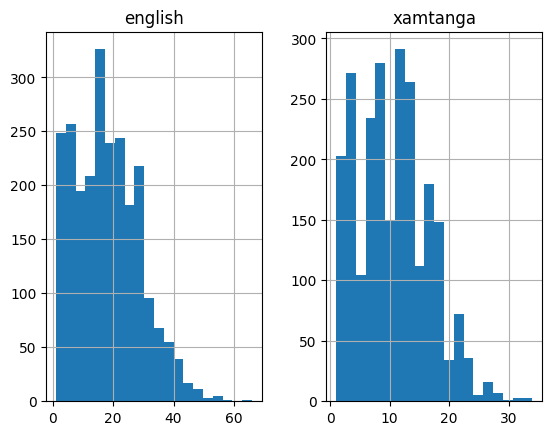

In [ ]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
xam_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))

for i in output_sentences:
      xam_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'xamtanga':xam_len})

length_df.hist(bins = 20)
plt.show()


The histogram above shows maximum length of the xamtanga sentences is 38 and that of the English sentence is 65.

For tokenization, the Tokenizer class from the keras.preprocessing.text library can be used. The tokenizer class performs two tasks:

1.It divides a sentence into the corresponding list of word

2.Then it converts the words to integers

Also the word_index attribute of the Tokenizer class returns a word-to-index dictionary where words are the keys and the corresponding integers are the values.

In [ ]:
#tokenize the input sentences(input language)
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)
print(input_integer_seq)

word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)


[[1927], [849], [319], [24, 476], [24, 976], [3, 304], [1928, 15], [24, 477], [24, 1436], [444, 1437], [82, 105], [82, 105], [476, 16], [106, 476], [246, 47], [214, 511], [19, 977], [19, 478], [19, 1929], [388, 47], [56, 15], [124, 511], [124, 41], [68, 60], [1438], [1930, 30], [3, 53], [3, 1439], [360, 47], [479, 30], [1931, 511], [24, 978], [444, 1932], [444, 286], [613, 1437], [613, 47], [198, 16], [850, 47], [78, 6], [1933, 45], [1934, 16], [139, 16], [1935, 45], [748, 45], [106, 101], [749], [23, 976], [6, 1154], [125, 199], [19, 180], [361, 30], [124, 60], [124, 84], [124, 1936], [979, 511], [979, 12], [37, 389], [3, 1440], [1937, 47], [1441, 45], [24, 1938], [24, 1939], [1940, 297], [444, 1442], [444, 1443], [444, 750], [444, 390], [444, 391], [421, 47], [1941, 68], [266, 41], [63, 1439], [259, 45], [7, 976], [3, 362], [511, 1436], [511, 1942], [980, 47], [476, 422], [476, 95], [23, 362], [614, 1943], [1155, 12], [56, 191], [42, 16, 140], [981, 1944], [982, 615], [979, 21], [979

In [ ]:
import re

def clean_text(text):
    #Clean text by removing unnecessary characters or contractions and altering the format of words.'''

    # Convert the entire text to lowercase
    text = text.lower()

    # Expand common contractions
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)

    return text



In [ ]:
import re

def normalize_english_sentence(sentence):
    # Convert to lowercase
    normalized_sentence = sentence.lower()

    # Remove extra whitespaces
    normalized_sentence = re.sub(r'\s+', ' ', normalized_sentence)

    # Remove leading and trailing whitespaces
    normalized_sentence = normalized_sentence.strip()

    # Remove punctuation
    normalized_sentence = re.sub(r'[^\w\s]', '', normalized_sentence)

    return normalized_sentence

# Example usage:
english_sentence = "   This is a SAMPLE sentence, with Punctuation!  "
normalized_sentence = normalize_english_sentence(english_sentence)
print(normalized_sentence)

this is a sample sentence with punctuation
